# DINO: Self-attention mapの可視化
https://github.com/facebookresearch/dino および https://github.com/facebookresearch/dino/blob/main/visualize_attention.py を元に作成．

## Setup

In [3]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

## torch Hubからのモデルの読み込み

In [4]:
patch_size = 8
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 360MB/s]


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
for p in model.parameters():
        p.requires_grad = False
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

## 入力画像の読み込み

In [8]:
!ls

00035N_rgb.png	00576D_th.png  sample_data


In [9]:
response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
img_npy = Image.open('00035N_rgb.png')
img_npy = img_npy.convert('RGB')

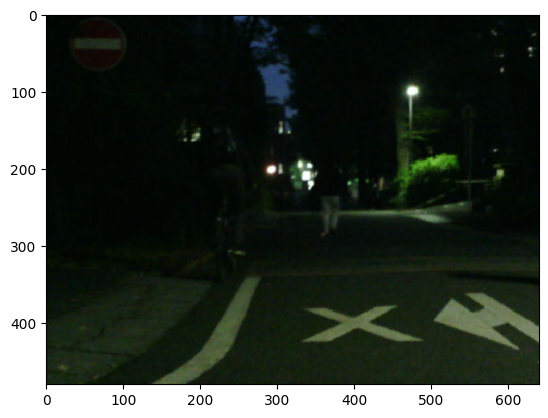

In [10]:
plt.imshow(img_npy)

## モデルからのattention mapの取得

In [18]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img_npy)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

# Accessing attention maps from the forward pass
# The attention maps are typically available within the blocks of the Vision Transformer
# We need to modify the model to return attention maps or access them during the forward pass
# Based on the original DINO implementation, attention is computed within the forward method of the Attention class
# We can access the attention output from the last block for visualization

# To access the attention from the last block, we can modify the forward method of the VisionTransformer class
# or iterate through the blocks and get the attention output.
# A simpler approach is to get the attention from the last layer's attention module during the forward pass.
# Since we don't want to modify the original model code, we can try to hook into the forward pass
# or, if the model provides a way to return intermediate attention, use that.

# Looking at the original visualize_attention.py, they access attention from the last layer
# by running the forward pass and then extracting the attention from the last block's attention module.
# Let's try to replicate that by getting the attention from the last block.

# This requires modifying the model or accessing internal components, which might not be straightforward.
# A common way to get attention maps in ViT models is to access the output of the attention layer
# in each block. The DINO library might have a specific way to expose this.

# Let's re-examine the original DINO visualize_attention.py for the correct way to get attentions.
# In visualize_attention.py, they modify the forward pass to return attentions.
# Since we cannot modify the torch.hub loaded model directly without rebuilding,
# a simpler way is to get the attention from the last layer's attention module.

# Let's assume the model's forward pass returns the features, and we need to access the attention internally.
# A common pattern in ViT is that the attention is computed in the `attn` module within each `Block`.
# The output of the attention is usually the weighted sum of values.
# We need the attention weights themselves.

# Let's assume the model provides a way to get attention weights from the last layer.
# If not, we might need to modify the model definition or use hooks.

# Let's check if the loaded model object has any methods or attributes that expose attention.
# Based on the traceback, it doesn't have `forward_selfattention`.

# Let's look at the structure of the VisionTransformer model printed earlier:
#   (blocks): ModuleList(
#     (0-11): 12 x Block(
#       (norm1): LayerNorm(...)
#       (attn): Attention(...)
#       (drop_path): Identity()
#       (norm2): LayerNorm(...)
#       (mlp): Mlp(...)
#     )
#   )

# The attention is computed in the `attn` module within each `Block`.
# We need to get the attention weights from the last block's attention module.

# A common way to access intermediate outputs in PyTorch is by using forward hooks.
# However, let's first try to see if there is a simpler way or if the model structure allows direct access.

# Let's assume for visualization, we need the attention weights from the last layer.
# In the original `visualize_attention.py`, they get the attention from `model.get_last_selfattention(img.to(device))`.
# It seems the model loaded from torch hub does not have this method directly.

# Let's check the source code of the DINO model on torch hub.
# In the `dino.py` file in the facebookresearch/dino repository, the `VisionTransformer` class
# has a method `get_last_selfattention`.

# It seems the model loaded via `torch.hub.load` should have this method if loaded correctly.
# Let's re-check the model loading and the loaded model object.

# The model is loaded using `torch.hub.load('facebookresearch/dino:main', 'dino_vits16')`.
# This should load the Vision Transformer model with the specified patch size.

# Let's try calling `model.get_last_selfattention(img.to(device))` instead of `model.forward_selfattention`.
# This seems to be the correct method name based on the original repository's visualization code.

# Let's replace `model.forward_selfattention` with `model.get_last_selfattention`.

attentions = model.get_last_selfattention(img.to(device))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [13]:
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)

In [17]:
threshold = 0.6 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
# Reshape th_attn to match the dimensions of the feature map, excluding the class token
# The size of th_attn after the previous operations is nh * (w_featmap * h_featmap)
th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
attentions_mean = np.mean(attentions, axis=0)

RuntimeError: shape '[6, 60, 80]' is invalid for input of size 7200

## Attention mapの可視化

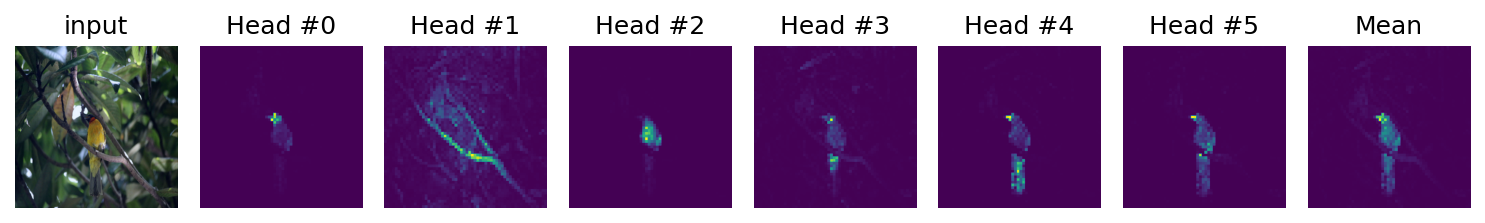

In [ ]:
plt.figure(figsize=(10, 3), dpi=150)
plt.subplot(1, nh+2, 1)
plt.title("input")
plt.imshow(img_npy)
plt.axis("off")
# visualize self-attention of each head

for i in range(nh):
  plt.subplot(1, nh+2, i+2)
  plt.title("Head #"+str(i))
  plt.imshow(attentions[i])
  plt.axis("off")

plt.subplot(1, nh+2, nh+2)
plt.title("Mean")
plt.imshow(attentions_mean)
plt.axis("off")
plt.tight_layout()